In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from utilities import *
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

<frozen importlib._bootstrap>:228: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


In [2]:
data = pd.read_csv('compas.csv', usecols=['Age=18-20', 'Race=African-American', 'Prior-Crimes=0','Gender=Male', 'Juvenile-Crimes=0', 'Current-Charge-Degree=Misdemeanor'])
X = data.rename({'Age=18-20':"age", 'Race=African-American':"race", 'Prior-Crimes=0':"prior", 'Gender=Male':"gender", 'Juvenile-Crimes=0':"juvenilecrime", 'Current-Charge-Degree=Misdemeanor':"currentcharge"}, axis='columns')
y = pd.read_csv('compas.csv', usecols=['Recidivate-Within-Two-Years'])
# y[y==0] = -1
vlist = ["age", "race", "prior", "gender", "juvenilecrime", "currentcharge"]
# vlist = ["age", "race", "prior", "gender"]
X = X[vlist]
y = y.to_numpy().reshape(len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2023, test_size=0.7)
# model = LogisticRegression(solver='liblinear').fit(X_train, y_train)
model = sm.Logit(y_train, sm.add_constant(X_train)).fit()


Optimization terminated successfully.
         Current function value: 0.638726
         Iterations 6


In [3]:
# loss0, bound_f, bound_f_half = find_boundary(y_test, model.predict(X_test), regression=False)
loss0, bound_f, bound_f_half = find_boundary(y_test, model.predict(sm.add_constant(X_test)),epsilon=0.1, regression=False)

loss0, bound_f, bound_f_half

(6.412213966205562e-01, 0.032061069831027814, 0.016030534915513907)

In [4]:
vt_f, points_all_max, points_all_min =find_VT(bound_f, loss0, vlist, model, X_test, y_test, delta=0.1, regression=False)

In [41]:
def loss_shuffle(values, v_idx, y_true, times=30):
    loss_all = []
    for i in range(times):
        np.random.shuffle(values[v_idx].values)
        pred = model.predict(sm.add_constant(values))
        loss = log_loss(y_true, pred)
        loss_all.append(loss)
    return np.mean(loss_all)

In [42]:
vt_fi = vt_f.copy()
for idx, i in enumerate(vlist):
    for j in range(len(vt_f[0])):
        for k in range(2):
            X0 = X_test.copy()
            coe = np.array(vt_f)[idx,j,k]
    #         coe_minus = vt[i,j,1]
            X0[i] = X0[i]*coe
            pred = model.predict(sm.add_constant(X0))
            myloss = log_loss(y_test, pred)
    #         np.random.shuffle(X0[i].values)
    #         pred = model.predict(sm.add_constant(X0))
            loss_changed = loss_shuffle(X0, i, y_test)
            ratio = loss_changed/myloss
            vt_fi[idx,j,k] = ratio
vt_fi

array([[[1.02445976, 1.01072741],
        [1.0358664 , 1.00202708],
        [1.04284439, 0.99728703],
        [1.05056855, 0.99381437],
        [1.05688063, 0.99039689],
        [1.06137603, 0.98774539],
        [1.06667159, 0.98598411],
        [1.06988832, 0.98348784],
        [1.07743151, 0.98184528],
        [1.08586667, 0.97809522],
        [1.08946652, 0.97682524]],

       [[1.01501271, 1.01067069],
        [1.02077786, 1.00480109],
        [1.0241038 , 1.00154967],
        [1.02512814, 0.9992956 ],
        [1.027726  , 0.99734087],
        [1.03015219, 0.99551504],
        [1.02985306, 0.99410614],
        [1.03223713, 0.99263666],
        [1.03410483, 0.99132384],
        [1.03613115, 0.98989377],
        [1.0357844 , 0.98919649]],

       [[1.05802415, 1.05619865],
        [1.07845834, 1.03626924],
        [1.08542077, 1.0279853 ],
        [1.09515495, 1.02143325],
        [1.10075568, 1.01619286],
        [1.1097222 , 1.01145938],
        [1.11205656, 1.00747436],
        [1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


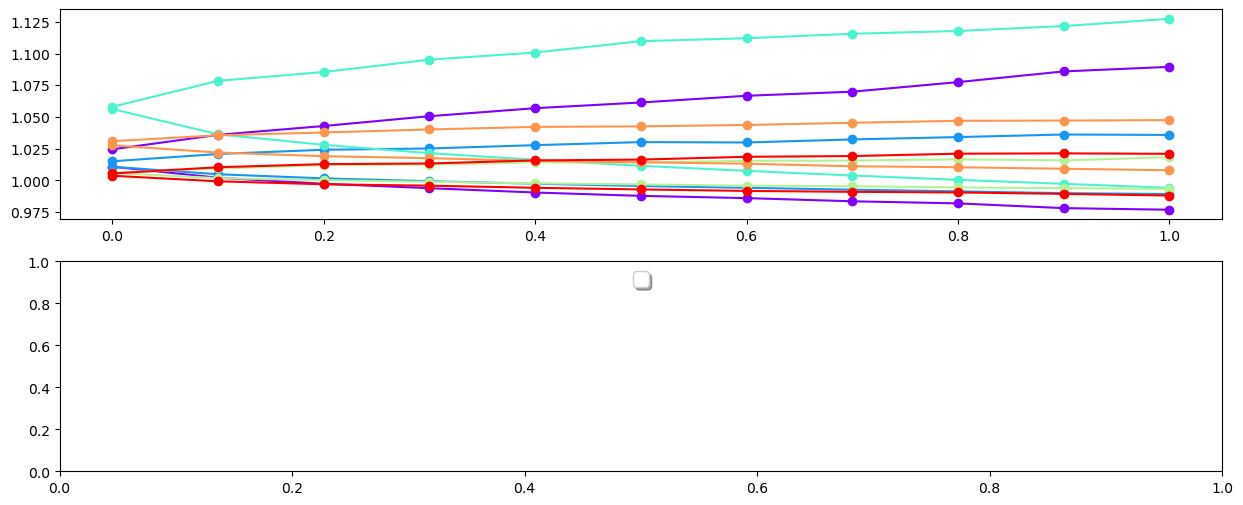

In [60]:
import matplotlib.cm as cm
fig, ax = plt.subplots(2,1, figsize=(15, 6), facecolor='w', edgecolor='k')
colors = cm.rainbow(np.linspace(0, 1, 6))
for i in range(len(vlist)):
#     xx, xy = zip(*sorted(zip(i[:,0],i[:,1])))
    xx = np.linspace(0,1,11)
    xy = vt_fi[i,:,0]
    yx = np.linspace(0,1,11)
    yy = vt_fi[i,:,1]
    ax[0].plot(yx, yy, marker='o', color = colors[i], label=vlist[i])
    ax[0].plot(xx, xy, marker='o', color = colors[i], label=vlist[i])
#     plt.plot(yx, yy, marker='.')
legend = ax[1].legend(loc='upper center', shadow=True, fontsize='x-large')

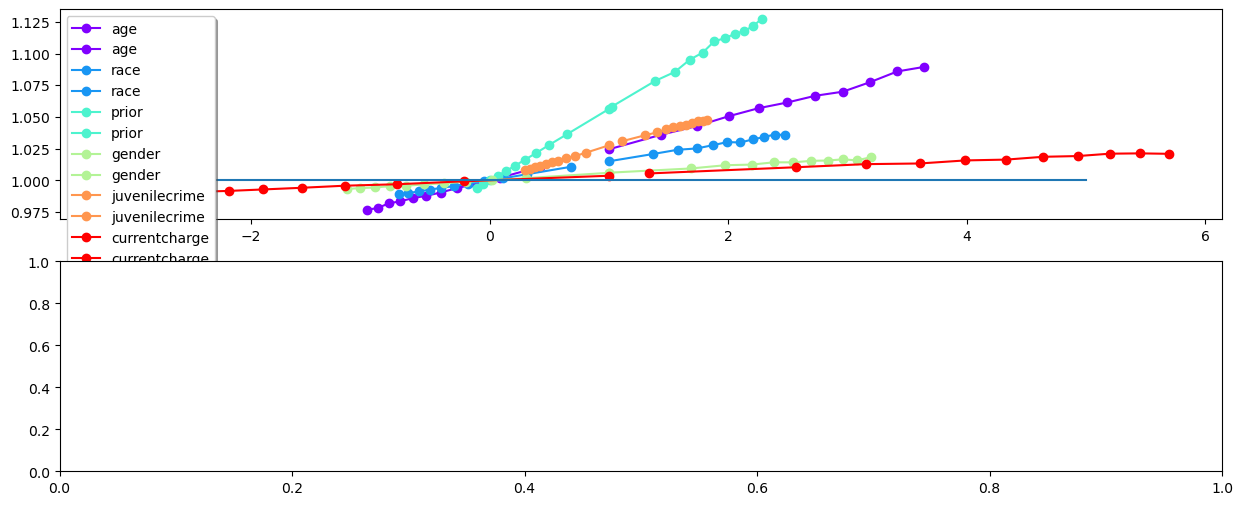

In [59]:
import matplotlib.cm as cm
fig, ax = plt.subplots(2,1, figsize=(15, 6), facecolor='w', edgecolor='k')
colors = cm.rainbow(np.linspace(0, 1, 6))
for i in range(len(vlist)):
#     xx, xy = zip(*sorted(zip(i[:,0],i[:,1])))
    xx = vt_f[i,:,0]
    xy = vt_fi[i,:,0]
    yx = vt_f[i,:,1]
    yy = vt_fi[i,:,1]
    ax[0].plot(yx, yy, marker='o', color = colors[i], label=vlist[i])
    ax[0].plot(xx, xy, marker='o', color = colors[i], label=vlist[i])
#     plt.plot(yx, yy, marker='.')
ax[0].plot(np.linspace(-3,5,11), np.ones(11))
legend = ax[0].legend(loc='upper left', shadow=True)

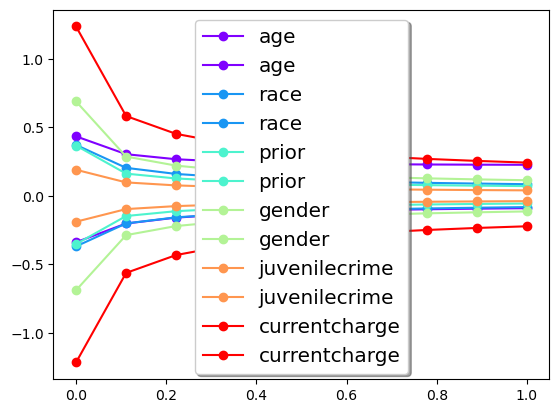

In [36]:
# plot derivitive
import matplotlib.cm as cm
vt_d1 = vt_f[:,1:,:] - vt_f[:,:-1,:]
colors = cm.rainbow(np.linspace(0, 1, 6))
for i in range(6):
    xx = np.linspace(0,1,10)
    yy1 = vt_d1[i,:,0]
    yy2 = vt_d1[i,:,1]
    plt.plot(xx, yy1, marker='o', color=colors[i], label=vlist[i])
    plt.plot(xx, yy2, marker='o', color=colors[i], label=vlist[i])
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')

/tmp/ipykernel_4039602/3691652793.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  points_all = [np.array(points_all_max)[:,-1][i]+np.array(points_all_min)[:,-1][i] for i, idx in enumerate(range(len(points_all_min))[::-1])]


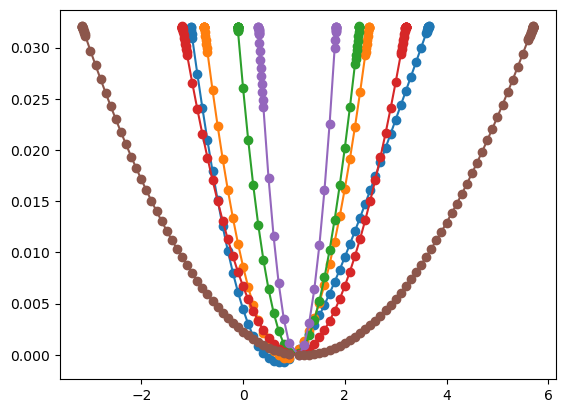

In [5]:
points_all = [np.array(points_all_max)[:,-1][i]+np.array(points_all_min)[:,-1][i] for i, idx in enumerate(range(len(points_all_min))[::-1])]

for i in points_all:
    i=np.array(i)
    xx, xy = zip(*sorted(zip(i[:,0],i[:,1])))
    plt.plot(xx, xy, marker='o')
#     plt.plot(i[:,0],i[:,1])

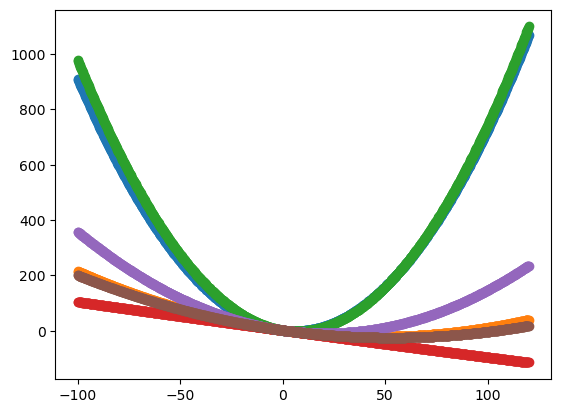

In [7]:
vt_regression = []
for i in range(6):
    x2 = np.polyfit(vt_f[i,:,0], vt_f[i,:,1], 2)
    x = np.linspace(-100,120,1000)
    y = x2[0]*(x**2)+x2[1]*x+x2[2]
    
    plt.plot(x, y, marker='o')
    vt_regression.append(np.polyfit(vt_f[i,:,0], vt_f[i,:,1], 2)[0])

In [34]:
myloss_all, diff_all = Interaction_effect_all_pairs(X_test, y_test, vlist, 2, model, vt_f, loss0, bound_f, regression=False)

In [35]:
feature_interaction_strength(diff_all, 2, bound_f)

array([3.22181864e-06, 4.76326786e-06, 3.64167037e-06, 2.75750276e-06,
       1.64052136e-06, 9.41373694e-06, 1.97340628e-05, 1.97530383e-05,
       1.15951417e-05, 1.32113620e-05, 1.58634663e-05, 1.15763737e-05,
       2.54863073e-05, 1.57247396e-05, 1.69704824e-05])

In [8]:
def MDS(vt_l, n_features_in, n_features_out=2):
    '''
    e.g. transform from n_features_inx10x2x10 to n_features_inx10x2x1
    '''
    vt_l_transformed_x = np.zeros((len(n_features_in), len(vt_l[-1]), n_features_out))
    vt_l_transformed_y = np.zeros((len(n_features_in), len(vt_l[-1]), n_features_out))
    
    d_old = vt_l-1
    vt_l_x = d_old[:,:,0]
    vt_l_y = d_old[:,:,1]
    # distance is (x_+, 1) (x_-, 1) to (1, 1)
    degree_avg = np.pi/len(n_features_in)
    for idx, i in enumerate(n_features_in):
        vt_l_transformed_x[i,:,0] = vt_l_x[i,:]*np.cos(idx*degree_avg)
        vt_l_transformed_x[i,:,1] = vt_l_x[i,:]*np.sin(idx*degree_avg)
        vt_l_transformed_y[i,:,0] = vt_l_y[i,:]*np.cos(idx*(degree_avg))
        vt_l_transformed_y[i,:,1] = vt_l_y[i,:]*np.sin(idx*(degree_avg))
    return vt_l_transformed_x, vt_l_transformed_y

In [110]:
s2 = (np.mean(1/abs(vt_f[:,:,0]-1), axis=1)+np.mean(1/abs(vt_f[:,:,1]-1), axis=1))/2

In [69]:
s1 = np.sqrt(np.sum(np.sum(np.square(vt_f-1),axis=1), axis=1)/20)

In [10]:
ranks = np.array((1/(vt_f[:,-1,0]-vt_f[:,-1,1]))).argsort()

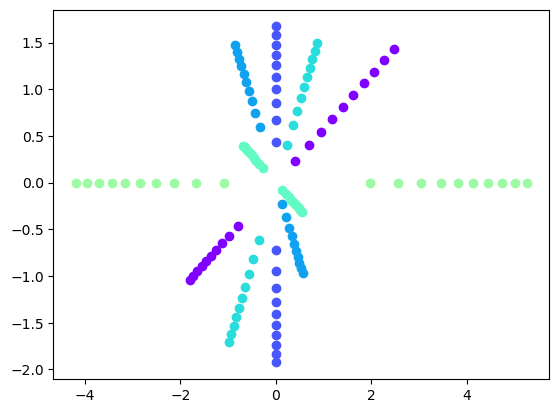

In [11]:
import matplotlib.cm as cm

vt_l_transformed_x, vt_l_transformed_y = MDS(vt_f, ranks, n_features_out=2)
colors = cm.rainbow(np.linspace(0, 1, 10))

for i in range(6):
    plt.scatter(vt_l_transformed_x[i, :,0], vt_l_transformed_x[i, :,1], color=colors[i])
    plt.scatter(vt_l_transformed_y[i,:,0], vt_l_transformed_y[i, :,1], color=colors[i])
    

In [12]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [13]:
model = SMWrapper(sm.Logit)
model = model.fit(sm.add_constant(X_train), y_train)

Optimization terminated successfully.
         Current function value: 0.643278
         Iterations 6


In [14]:
from sklearn.inspection import partial_dependence

univariate = {}
for i in vlist:
    univariate[i] = partial_dependence(model, sm.add_constant(X_test), features=[i], kind='average')['average']
    
bivariate = {}
for i, j in itertools.combinations(vlist,2):
    bivariate[(i, j)] = partial_dependence(model, sm.add_constant(X_test), features=[i, j], kind='average')['average']

In [15]:
h = np.zeros((len(vlist), len(vlist)))
for i, j in itertools.combinations(vlist, 2):
    iidx = np.nonzero(np.in1d(vlist, i))[0]
    jidx = np.nonzero(np.in1d(vlist, j))[0]
    h[iidx, jidx] = np.sum(np.square(bivariate[(i, j)] - univariate[i].reshape(1, -1, 1) - univariate[j].reshape(1, 1, -1) )) / np.sum(np.square(bivariate[(i, j)]))
#     h[i, j] = np.sum(np.square(bivariate[(i, j)] - univariate[i].reshape(1, -1, 1) - univariate[j].reshape(1, 1, -1))) / np.sum(np.square(bivariate[(i, j)]))

h

array([[0.        , 0.51259569, 0.53082566, 0.53046806, 0.48486597,
        0.51929959],
       [0.        , 0.        , 1.11402784, 1.0844804 , 0.7437107 ,
        1.01753573],
       [0.        , 0.        , 0.        , 1.22829649, 0.82699542,
        1.15113395],
       [0.        , 0.        , 0.        , 0.        , 0.80505327,
        1.11982808],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.76259186],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

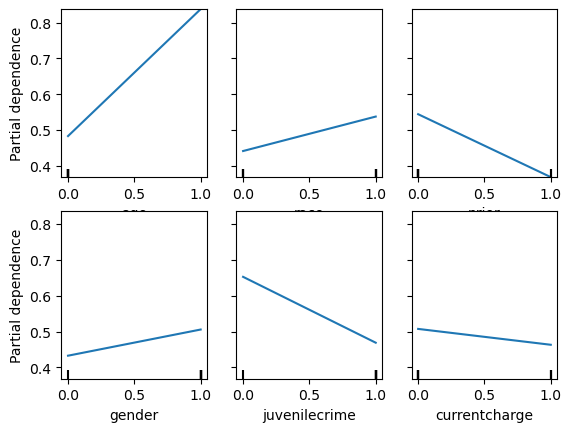

In [16]:
from sklearn.inspection import plot_partial_dependence
plot_partial_dependence(model, sm.add_constant(X_train), vlist)

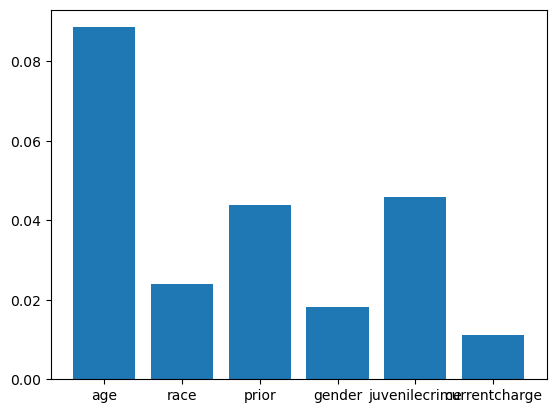

In [105]:
from sklearn.inspection import partial_dependence
# PDP feature importance by Brandon
VI_pdp = []

for vname in vlist:
    crime_pd=partial_dependence(model, features=[vname], X=sm.add_constant(X_train))['average'][0]
    VI_pdp.append((np.max(crime_pd)-np.min(crime_pd))/4)
plt.bar(vlist, VI_pdp)
# plt.xticks(range(len(model.feature_importances_)), train_features.columns)
plt.show()

In [19]:
vt_f

array([[[ 1.4346,  0.085 ],
        [ 1.7389, -0.117 ],
        [ 2.0062, -0.2759],
        [ 2.256 , -0.4118],
        [ 2.4964, -0.5332],
        [ 2.7311, -0.6445],
        [ 2.9624, -0.7483],
        [ 3.1915, -0.8464],
        [ 3.4192, -0.9401],
        [ 3.6461, -1.0301]],

       [[ 1.372 ,  0.3124],
        [ 1.5765,  0.1109],
        [ 1.7364, -0.046 ],
        [ 1.8726, -0.1792],
        [ 1.9935, -0.2971],
        [ 2.1034, -0.4041],
        [ 2.2051, -0.5027],
        [ 2.3001, -0.5948],
        [ 2.3898, -0.6815],
        [ 2.475 , -0.7636]],

       [[ 1.3901,  0.6477],
        [ 1.5523,  0.5004],
        [ 1.6792,  0.3885],
        [ 1.7879,  0.2947],
        [ 1.8852,  0.2124],
        [ 1.9744,  0.1384],
        [ 2.0575,  0.0705],
        [ 2.1358,  0.0074],
        [ 2.2101, -0.0517],
        [ 2.2813, -0.1076]],

       [[ 1.69  ,  0.3072],
        [ 1.977 ,  0.0203],
        [ 2.1976, -0.2002],
        [ 2.3839, -0.3863],
        [ 2.5484, -0.5507],
        [ 2.69

In [34]:
vt_d1_sum = np.sum(vt_f[:,1:,:] - vt_f[:,:-1,:], axis=1)

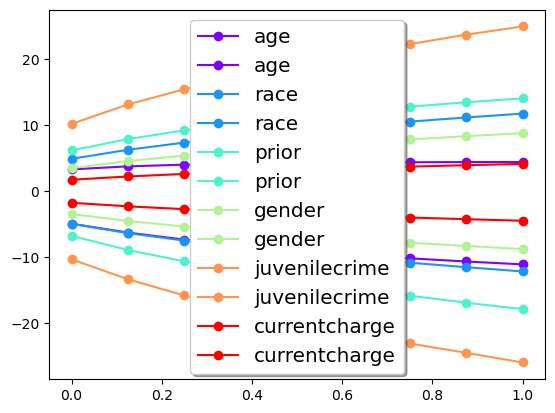

In [64]:
# plot derivitive
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, 6))
for i in range(6):
    xx = np.linspace(0,1,9)
    yy1 = vt_d1[i,:,0]
    yy2 = vt_d1[i,:,1]
    plt.plot(xx, yy1, marker='o', color=colors[i], label=vlist[i])
    plt.plot(xx, yy2, marker='o', color=colors[i], label=vlist[i])
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')

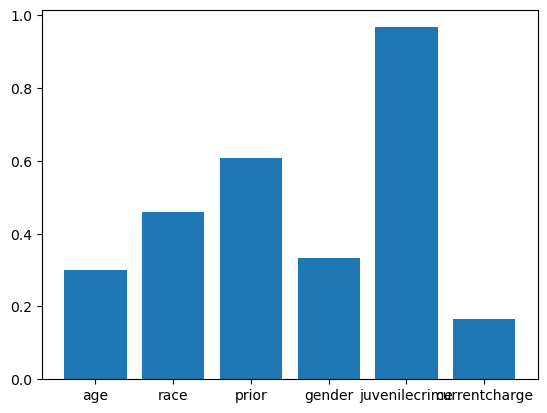

In [67]:
import matplotlib.pyplot as plt
plt.bar(vlist,1/(vt_d1[:,0]+abs(vt_d1[:,1])))
# plt.xticks(range(len(model.feature_importances_)), train_features.columns)
plt.show()

In [21]:
feature_interaction_strength(diff_all, 2, bound_f)*1000

array([0.1562243 , 0.14002073, 0.15668729, 0.14714815, 0.13973682,
       0.15954326, 0.36130876, 0.36042332, 0.19507846, 0.21400679,
       0.24804756, 0.19315262, 0.46341619, 0.26464619, 0.27923611])

In [22]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, sm.add_constant(X_test), y_test,n_repeats=30,random_state=0)

In [134]:
rr=[]
for idx, i in enumerate(vlist):
    for j in range(len(vt_f[0])):
        X0=X_test.copy()
        X0[i] = X0[i]*vt_f[idx,j,0]
        r0=permutation_importance(model, sm.add_constant(X0), y_test,n_repeats=10,random_state=0)
        rr.append(r0.importances_mean[1:])
        X0=X_test.copy()
        X0[i] = X0[i]*vt_f[idx,j,1]
        r1=permutation_importance(model, sm.add_constant(X0), y_test,n_repeats=5,random_state=0)
        rr.append(r1.importances_mean[1:])

In [23]:
r.importances_mean

array([0.        , 0.02413972, 0.0174348 , 0.05895376, 0.00786122,
       0.03456959, 0.00456071])

In [139]:
np.min(rr, axis=0)

array([-0.02197911, -0.01694198, -0.00736542, -0.0076779 ,  0.01322106,
       -0.01357629])

In [141]:
np.max(rr, axis=0)

array([0.0370019 , 0.04917973, 0.14378014, 0.02196001, 0.0642304 ,
       0.03065495])

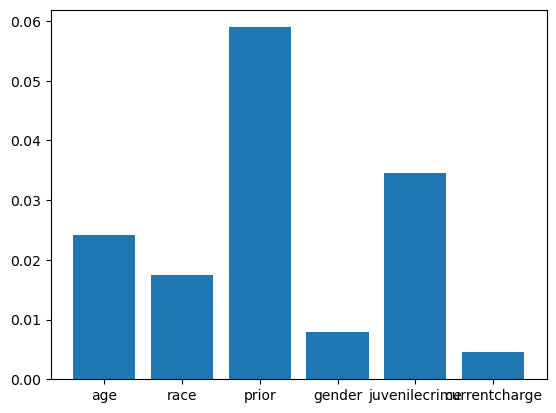

In [157]:
plt.bar(vlist,r.importances_mean[1:])
# plt.xticks(range(len(model.feature_importances_)), train_features.columns)
plt.show()

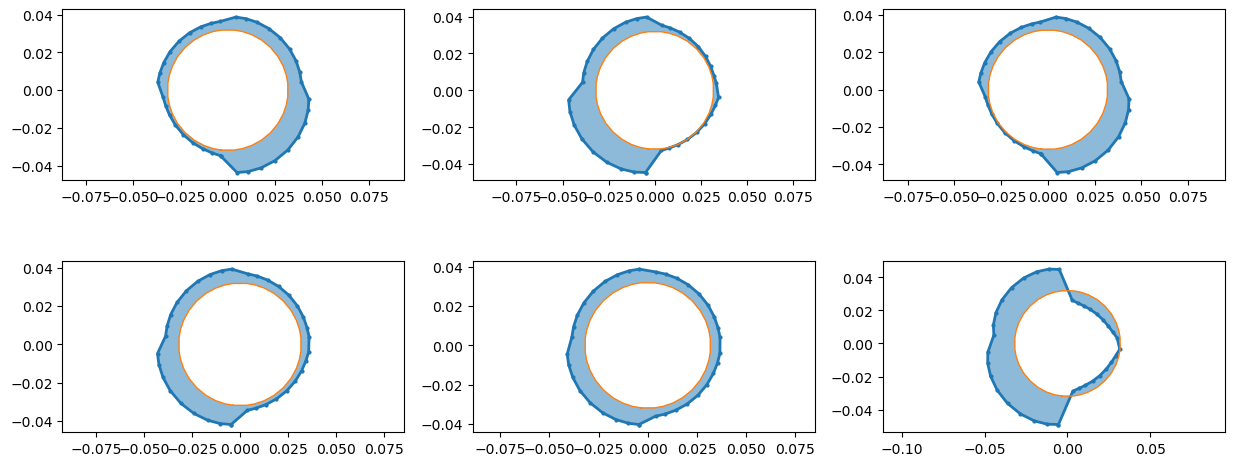

In [36]:
fig, axs = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(6):
    cor,circle = diff_points_cal(sum_to_one_pairs, diff_all[i], bound_f)
    
    cor.sort(key=lambda c:np.arctan2(c[0], c[1]))
    cor.append(cor[0])
    
    circle.sort(key=lambda c:np.arctan2(c[0], c[1]))
    circle.append(circle[0])
#     xx, xy = zip(*sorted(zip(cor[:,0],cor[:,1])))
    axs[i].plot(np.array(cor)[:,0], np.array(cor)[:,1], marker='o', linewidth=2, markersize=2)
    axs[i].plot(np.array(circle)[:,0], np.array(circle)[:,1], linewidth=1, markersize=1)
    axs[i].fill(np.concatenate((np.array(cor)[:,0], np.array(circle)[:,0][::-1])), np.concatenate((np.array(cor)[:,1], np.array(circle)[:,1][::-1])), alpha=0.5)
    max_cir = np.max(diff_all[i])
    min_cir = np.min(diff_all[i])
    avg_cir = np.average(diff_all[i])
#     axs[i].add_patch(plt.Circle((0, 0), avg_cir+bound_f, fill=False, linestyle='--', color='r'))
#     axs[i].add_patch(plt.Circle((0, 0), min_cir+bound_f, fill=False, linestyle='--', color='g'))
#     axs[i].add_patch(plt.Circle((0, 0), max_cir+bound_f, fill=False, linestyle='--', color='purple'))
    
    # ax.add_patch(plt.Circle((0, 0), bound_f, fill=False))
    axs[i].set_aspect("equal", adjustable="datalim")
    axs[i].set_box_aspect(0.5)
    axs[i].autoscale()



plt.show()


In [44]:
vt_f_diff = vt_f[:,:,0]-vt_f[:,:,1]

In [46]:
vt_f_diff/vt_f_diff[0,:]

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.82969901, 0.83457172, 0.82460908, 0.81100845, 0.79635087,
        0.78151685, 0.76691077, 0.75274584, 0.73907956, 0.72593729],
       [0.68127547, 0.66625387, 0.65214483, 0.63856883, 0.62558781,
        0.61323034, 0.60141359, 0.59022037, 0.57954151, 0.56939344],
       [0.84628584, 0.85515996, 0.84609917, 0.83255449, 0.81760612,
        0.80241573, 0.78732362, 0.77265169, 0.75842867, 0.74476371],
       [0.33502538, 0.33286894, 0.32736851, 0.32119288, 0.31481598,
        0.30856742, 0.30251844, 0.29666753, 0.29105998, 0.28570564],
       [2.18788875, 2.19267286, 2.1643114 , 2.12792066, 2.08934729,
        2.05070225, 2.01275803, 1.97606613, 1.94069596, 1.90675572]])

In [47]:
vt_f/vt_f[0,:]

array([[[ 1.00000000e+00,  1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00]],

       [[ 9.76374745e-01,  3.73755047e+00],
        [ 9.26627416e-01, -3.69912791e-01],
        [ 8.84600651e-01,  4.11667765e-01],
        [ 8.47862958e-01,  6.15643965e-01],
        [ 8.15137282e-01,  7.10208370e-01],
        [ 7.85577559e-01,  7.64525994e-01],
        [ 7.58689112e-01,  7.99244808e-01],
        [ 7.34068410e-01,  8.23050318e-01],
        [ 7.11433857e-01,  8.39859084e-01],
        [ 6.90550041e-01,  8.51885925e-01]],

       [[ 1.14202308e+00,  9.81561238e+00],
        [ 1.03327038e+00, -4.13590116e+00],
        [ 9.59394752e-01, -1